In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd



import pysd
from SALib.sample import saltelli
from SALib.analyze import sobol
import scipy as sp

# Load Calibration data

In [2]:
data = pd.read_csv("/Users/adenooy/Library/CloudStorage/OneDrive-Personal/UVA/Thesis/MSc-Thesis/data/dynamic/calibration_incidence.csv", sep=',',decimal='.')
data=data.drop("Unnamed: 0",axis=1)
data.head(23)


,year,var,Lower,Mean,Upper
0,2000,e_inc_num,56000,139000,259000
1,2001,e_inc_num,57000,159000,312000
2,2002,e_inc_num,57000,175000,357000
3,2003,e_inc_num,54000,206000,456000
4,2004,e_inc_num,54000,221000,501000
5,2005,e_inc_num,56000,226000,510000
6,2006,e_inc_num,56000,239000,549000
7,2007,e_inc_num,60000,235000,525000
8,2008,e_inc_num,66000,221000,467000
9,2009,e_inc_num,68000,228000,483000


Text(0.5, 1.0, 'Estimated Incident cases of TB')

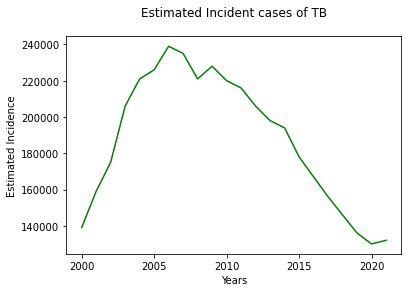

In [3]:
plt.plot(data["year"], data['Mean'],label="mean_estimate",color="green")
plt.xlabel('Years')
plt.ylabel('Estimated Incidence')
plt.title("Estimated Incident cases of TB",pad=20)

# Load Model

In [43]:
model = pysd.read_vensim("/Users/adenooy/Library/CloudStorage/OneDrive-Personal/UVA/Thesis/MSc-Thesis/model/transmission/V12_years.mdl")

In [44]:
model_output = model.run()


<AxesSubplot:>

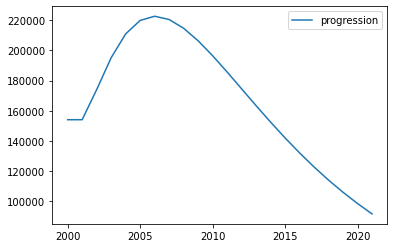

In [45]:
model_output.plot(y="progression")

## Calibration

In [46]:
#Set up observable and claibration parameters
observable = "progression"
parameter1 = 'transmission rate'
parameter2 = 'relapse rate'
parameter3 = 'initial incident'
parameter4="progression rate"
parameter5 = 'initial latent'
parameter6 = 'progression time'




def error(param_list):
    #unpack the parameter list
    parameter1_value,parameter2_value,parameter3_value,parameter4_value,parameter5_value,parameter6_value = param_list
    #run the model with the new parameters, returning the info we're interested in
    result = model.run(params={'transmission rate':parameter1_value,
                               'relapse rate':parameter2_value,
                               'initial incident': parameter3_value,
                               "progression rate":parameter4_value,
                               'initial latent': parameter5_value,
                               'progression time': parameter6_value
                              },
                       return_columns=['progression'])
    #print(result['progression'] -data['Mean'])
    
    result=result.reset_index(drop=True)
    #print(result)
    calDat=data.reset_index(drop=True)
    calDat=calDat["Mean"]
    
    error=sum((result['progression'] - calDat)**2)
    #print(error)
    #return the sum of the squared errors
    return  error

In [47]:
parameter1_guess = 0.05
parameter1_bounds = (0.0, 1)

parameter2_guess = 0.1
parameter2_bounds = (0.004, 0.1)

parameter3_guess = 100000
parameter3_bounds = (1, 3000000)

parameter4_guess = 0.08
parameter4_bounds = (0, 0.2)


parameter5_guess = 100000
parameter5_bounds = (1, 3000000)

parameter6_guess = 2
parameter6_bounds = (1,5)



res = sp.optimize.minimize(error,
                           x0=[parameter1_guess,parameter2_guess,parameter3_guess,parameter4_guess,parameter5_guess,parameter6_guess],
                           method='L-BFGS-B',
                           bounds=[parameter1_bounds,parameter2_bounds,parameter3_bounds,parameter4_bounds,parameter5_bounds,parameter6_bounds])
res

      fun: 12451393942.95793
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.36827659e+08,  1.74357467e+11, -1.23832558e+04,  5.16590119e+08,
        2.73066667e+03,  8.36086278e+07])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 693
      nit: 59
     njev: 99
   status: 0
  success: True
        x: array([5.10318260e-01, 4.00000000e-03, 9.03132638e+05, 9.02703057e-02,
       2.17238147e+06, 3.40954528e+00])

In [48]:
p1, p2, p3,p4,p5,p6= res.x
result = model.run(params=
                   {
                       'transmission rate':p1,
                               'relapse rate':p2,
                               'initial incident': p3,
                               "progression rate":p4,
                       'initial latent': p5,
                       'progression time': p6
                   },
                   return_columns=['progression'])

result

,progression
2000,196101.539558
2001,196101.539558
2002,201647.966528
2003,206872.517169
2004,210018.357696
2005,210945.728990
2006,210051.499870
2007,207828.738192
2008,204709.363404
2009,201025.518480


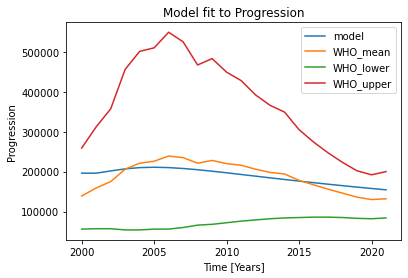

In [49]:
plt.plot(result.index, result['progression'],label="model")
plt.plot(data["year"], data['Mean'], label='WHO_mean');
plt.plot(data["year"], data['Lower'], label='WHO_lower');
plt.plot(data["year"], data['Upper'], label='WHO_upper');
plt.xlabel('Time [Years]')
plt.ylabel('Progression')

plt.title('Model fit to Progression')
plt.legend(loc='upper right')
#plt.text(30,750000000, 'RMSE: 7.39% of Max', color='r', fontsize=12)

## Explore Calibrated

In [ ]:
model_cal = pysd.read_vensim("/Users/adenooy/Library/CloudStorage/OneDrive-Personal/UVA/Thesis/MSc-Thesis/model/transmission/V11_years_cal.mdl")

In [ ]:
model_cal_output = model_cal.run()
display(model_cal_output)

In [ ]:
plt.plot(model_cal_output.index, model_cal_output['progression'],label="model")
plt.plot(data["year"], data['Mean'], label='WHO_mean');
plt.plot(data["year"], data['Lower'], label='WHO_lower');
plt.plot(data["year"], data['Upper'], label='WHO_upper');
plt.xlabel('Time [Years]')
plt.ylabel('Progression')
plt.title('Model fit to Progression')
plt.legend(loc='upper right')
#plt.text(30,750000000, 'RMSE: 7.39% of Max', color='r', fontsize=12)